In [13]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Overview
- In 'sklearn_kmeans_iris' notebook, I described the failure of kmeans algorithm due to its spherical assumption.
- In Iris data, features are highly correlated each other so the shape of cluster would not be spherical.
- In this case, we can utilize GMM clustering algorithm as an alternative.

# Gaussian Mixture Models clustering
GMM is a probabilistic model that assumes all the data points are generated from mixture of k (# of clusters) Gaussian distributions.

# Learning step of GMM
- Assume there are k gaussian distribution with different weight. And its weight is represeted by $\pi_k$.
- Associate a weight $\pi_k$ with condition $\sum \pi_k = 1$ for each Gaussian component.
- When we set parameter $\mu_k$ as a mean of Gaussian distribution and $\sigma_k$ as a standard deviation of Gaussian distiribution, each mixture component represents a unique cluster specified by $(\pi_k, \mu_k, \sigma_k)$
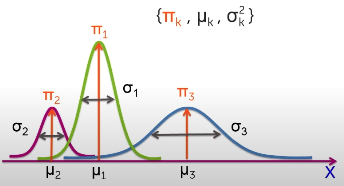

- Assume all data points (observation $x_i$) are from cluster 1 to k, then the liklihood  of seeing x can be defined as 
$$
p(x_i) = \sum_k \pi_k N(x_i|\mu_k, \sigma_k)
$$
- Next, given observation $x_i$ is from cluster k, then the liklihood of seeing $x_i$ is defined as 
$$
N(x_i|\mu_k, \sigma_k) = \frac{1}{(2\pi)^{D/2} \sigma_k^{1/2}} exp\{-\frac{1}{2}(x_i-\mu_k)^T \sigma_k^{-1}(x_i-\mu_k)\}
$$

Step of iterative learning process
1. Initialize $(\pi_k, \mu_k, \sigma_k)$ for each distribution.
2. Repeat till convergence with EM algorithm
    - Expectation step (E-step): Estimate the latent lables k by finding the expected value of k given E(k|$(x, \pi_k, \mu_k, \sigma_k)$)
    - Maximization step (M-step): Estimate the parameters $(\pi_k, \mu_k, \sigma_k)$ given the latent labels

- Extension of MLE for latent variables
    - MLE: argmax log(p(x|$(\pi_k, \mu_k, \sigma_k)$)
    - EM: argmax $E_k[log(p(x, k | (\pi_k, \mu_k, \sigma_k))]$


In [21]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
series1 = pd.Series(data=[iris.target_names[i] for i in iris.target], name="kind")
df = pd.concat([df,series1], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),kind
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [22]:
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

my_preprocessor_numeric = make_pipeline(
    StandardScaler(),
    PCA(n_components=4)
)
preprocessor_list = [
    ('drop_features', 'drop', []),
    ('numeric_scaler_features', my_preprocessor_numeric, ['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']),
    ('pass_features', 'passthrough', ['kind']),
]

my_preprocess = ColumnTransformer(
    preprocessor_list,
    remainder='drop'
)
df_trans = Pipeline([
    ('prep', my_preprocess)
]).fit_transform(df)
df_trans = pd.DataFrame(df_trans, columns=['PC1', 'PC2', 'PC3', 'PC4', 'kind'])
display(df_trans.head())

,PC1,PC2,PC3,PC4,kind
0,-2.264703,0.480027,-0.127706,-0.024168,setosa
1,-2.080961,-0.674134,-0.234609,-0.103007,setosa
2,-2.364229,-0.341908,0.044201,-0.028377,setosa
3,-2.299384,-0.597395,0.09129,0.065956,setosa
4,-2.389842,0.646835,0.015738,0.035923,setosa


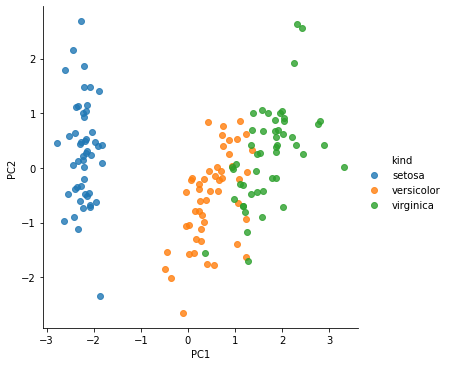

In [23]:
sns.lmplot( x="PC1", y="PC2", data=df_trans, fit_reg=False, hue='kind', legend=True)
plt.show()

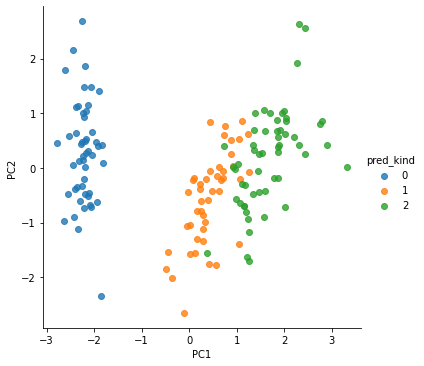

In [28]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(df_trans[['PC1','PC2','PC3','PC4']])
df_trans['pred_kind'] = gmm.predict(df_trans[['PC1','PC2','PC3','PC4']])
sns.lmplot(x="PC1", y="PC2", data=df_trans, fit_reg=False, hue='pred_kind', legend=True)
plt.show()

Parameter covariance_type   
https://scikit-learn.org/stable/modules/mixture.html


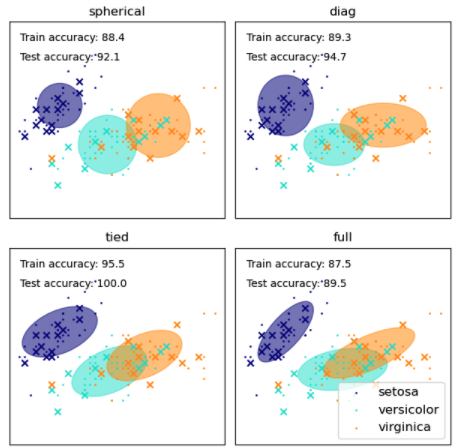

### Finding cluster N by calculating BIC

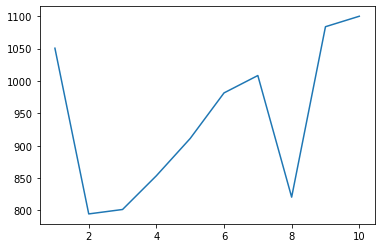

In [19]:
bic_list = []
for i in range(1, 10 + 1):
    gmm = GaussianMixture(n_components=i, covariance_type='full')
    gmm.fit(df_trans[['PC1','PC2','PC3','PC4']])
    bic_list.append(gmm.bic(df_trans[['PC1','PC2','PC3','PC4']]))
plt.plot(list(range(1, 10 + 1)), bic_list)
plt.show()

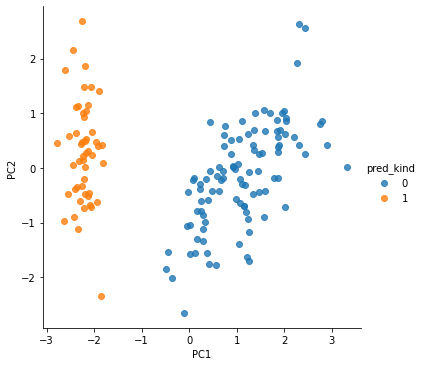

In [20]:
gmm = GaussianMixture(n_components=2)
gmm.fit(df_trans[['PC1','PC2','PC3','PC4']])
df_trans['pred_kind'] = gmm.predict(df_trans[['PC1','PC2','PC3','PC4']])
sns.lmplot(x="PC1", y="PC2", data=df_trans, fit_reg=False, hue='pred_kind', legend=True)
plt.show()

Judging solely from the data, it seems natural to divide them into two clusters.